In [1]:
!apt-get  -qq  install  -y  graphviz  &&  pip  install  pydot
!pip  install  -U  matplotlib
!pip  install  git+https://github.com/fastmachinelearning/hls4ml.git@main#egg=hls4ml[profiling]
!pip  install  qkeras==0.9.0

/bin/bash: apt-get: command not found
  Cloning https://github.com/fastmachinelearning/hls4ml.git (to revision main) to /private/var/folders/3l/14rcjzxj1t3gv_xqt_53y5yw0000gn/T/pip-install-24ngfvhk/hls4ml_618367b511854885a741d64cf1a6b2fc
  Running command git clone --filter=blob:none --quiet https://github.com/fastmachinelearning/hls4ml.git /private/var/folders/3l/14rcjzxj1t3gv_xqt_53y5yw0000gn/T/pip-install-24ngfvhk/hls4ml_618367b511854885a741d64cf1a6b2fc
  Resolved https://github.com/fastmachinelearning/hls4ml.git to commit 62046d799a4dbec150addc7f78fea5b579efeda1
  Running command git submodule update --init --recursive -q
  Preparing metadata (setup.py) ... done


In [ ]:
COLAB=True

In [ ]:
!pip install wget
import wget
import os.path
# WGET for colab
if not os.path.exists("callbacks.py"):
    url = "https://raw.githubusercontent.com/jmduarte/iaifi-summer-school/main/book/callbacks.py"
    callbacksFile = wget.download(url)
if not os.path.exists("plotting.py"):
    urlPlot = "https://raw.githubusercontent.com/jmduarte/iaifi-summer-school/main/book/plotting.py"
    plotFile = wget.download(urlPlot)

In [ ]:
if COLAB:
    if not os.path.exists("./iaifi-summer-school"):
        !git clone https://github.com/jmduarte/iaifi-summer-school.git

# Compression (Pruning)

## Load the dataset (if you are restarting from this point)

In [2]:
from tensorflow.keras.utils import to_categorical
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
seed = 0
np.random.seed(seed)
import tensorflow as tf

tf.random.set_seed(seed)
# import os
# os.environ['PATH'] = '/opt/Xilinx/Vivado/2019.2/bin:' + os.environ['PATH']
# for this tutorial we wont be actually running Vivado, so I have commented these lines out
#     but if you want to look into actually running on an FPGA then simply uncomment these lines

if not COLAB:
    #FOR LOCAL PULL
    X_train_val = np.load("X_train_val.npy")
    X_test = np.load("X_test.npy")
    y_train_val = np.load("y_train_val.npy")
    y_test = np.load("y_test.npy")
    classes = np.load("classes.npy", allow_pickle=True)

if COLAB:
    #FOR COLAB
    X_train_val = np.load("iaifi-summer-school/book/X_train_val.npy")
    X_test = np.load("iaifi-summer-school/book/X_test.npy")
    y_train_val = np.load("iaifi-summer-school/book/y_train_val.npy")
    y_test = np.load("iaifi-summer-school/book/y_test.npy")
    classes = np.load("iaifi-summer-school/book/classes.npy", allow_pickle=True)

'\n#FOR COLAB\nX_train_val = np.load("iaifi-summer-school/book/X_train_val.npy")\nX_test = np.load("iaifi-summer-school/book/X_test.npy")\ny_train_val = np.load("iaifi-summer-school/book/y_train_val.npy")\ny_test = np.load("iaifi-summer-school/book/y_test.npy")\nclasses = np.load("iaifi-summer-school/book/classes.npy", allow_pickle=True)\n'

## Construct a new model
We'll now use the same architecture as we originally used: 3 hidden layers with 64, then 32, then 32 neurons. Each layer will use `relu` activation.
Add an output layer with 5 neurons (one for each class), then finish with Softmax activation.

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1
from callbacks import all_callbacks

In [4]:
model = Sequential()
model.add(
    Dense(
        64,
        input_shape=(16,),
        name="fc1",
        kernel_initializer="lecun_uniform",
        kernel_regularizer=l1(0.0001),
    )
)
model.add(Activation(activation="relu", name="relu1"))
model.add(
    Dense(
        32,
        name="fc2",
        kernel_initializer="lecun_uniform",
        kernel_regularizer=l1(0.0001),
    )
)
model.add(Activation(activation="relu", name="relu2"))
model.add(
    Dense(
        32,
        name="fc3",
        kernel_initializer="lecun_uniform",
        kernel_regularizer=l1(0.0001),
    )
)
model.add(Activation(activation="relu", name="relu3"))
model.add(
    Dense(
        5,
        name="output",
        kernel_initializer="lecun_uniform",
        kernel_regularizer=l1(0.0001),
    )
)
model.add(Activation(activation="softmax", name="softmax"))

2022-08-01 20:52:14.577080: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Train sparse
This time we'll use the Tensorflow model optimization sparsity to train a sparse model (forcing many weights to '0'). In this instance, the target sparsity is 75%

In [5]:
from tensorflow_model_optimization.python.core.sparsity.keras import (
    prune,
    pruning_callbacks,
    pruning_schedule,
)
from tensorflow_model_optimization.sparsity.keras import strip_pruning

pruning_params = {
    "pruning_schedule": pruning_schedule.ConstantSparsity(
        0.75, begin_step=2000, frequency=100
    )
}
model = prune.prune_low_magnitude(model, **pruning_params)

## Train the model
We'll use the same settings as the previous model: Adam optimizer with categorical crossentropy loss.
The callbacks will decay the learning rate and save the model into a directory 'model_3'
The model isn't very complex, so this should just take a few minutes even on the CPU.
If you've restarted the notebook kernel after training once, set `train = False` to load the trained model rather than training again.

In [6]:
train = True
if train:
    adam = Adam(lr=0.0001)
    model.compile(
        optimizer=adam, loss=["categorical_crossentropy"], metrics=["accuracy"]
    )
    callbacks = all_callbacks(
        stop_patience=1000,
        lr_factor=0.5,
        lr_patience=10,
        lr_epsilon=0.000001,
        lr_cooldown=2,
        lr_minimum=0.0000001,
        outputDir="model_3",
    )
    callbacks.callbacks.append(pruning_callbacks.UpdatePruningStep())
    model.fit(
        X_train_val,
        y_train_val,
        batch_size=1024,
        epochs=30,
        validation_split=0.25,
        shuffle=True,
        callbacks=callbacks.callbacks,
    )
    # Save the model again but with the pruning 'stripped' to use the regular layer types
    model = strip_pruning(model)
    model.save("model_3/KERAS_check_best_model.h5")
else:
    from tensorflow.keras.models import load_model

    model = load_model("model_3/KERAS_check_best_model.h5")

Epoch 1/30


/Users/wmccorma/miniconda3/envs/ml-iaifi/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


476/487 [============================>.] - ETA: 0s - loss: 1.3336 - accuracy: 0.5135
***callbacks***
saving losses to model_3/losses.log

Epoch 1: val_loss improved from inf to 1.12515, saving model to model_3/KERAS_check_best_model.h5

Epoch 1: val_loss improved from inf to 1.12515, saving model to model_3/KERAS_check_best_model_weights.h5

Epoch 1: saving model to model_3/KERAS_check_model_last.h5

Epoch 1: saving model to model_3/KERAS_check_model_last_weights.h5

***callbacks end***

487/487 [==============================] - 3s 3ms/step - loss: 1.3290 - accuracy: 0.5161 - val_loss: 1.1252 - val_accuracy: 0.6363 - lr: 1.0000e-04
Epoch 2/30
471/487 [============================>.] - ETA: 0s - loss: 1.0569 - accuracy: 0.6660
***callbacks***
saving losses to model_3/losses.log

Epoch 2: val_loss improved from 1.12515 to 1.00706, saving model to model_3/KERAS_check_best_model.h5

Epoch 2: val_loss improved from 1.12515 to 1.00706, saving model to model_3/KERAS_check_best_model_weights.


Epoch 13: saving model to model_3/KERAS_check_model_last.h5

Epoch 13: saving model to model_3/KERAS_check_model_last_weights.h5

***callbacks end***

487/487 [==============================] - 1s 3ms/step - loss: 0.8219 - accuracy: 0.7263 - val_loss: 0.8222 - val_accuracy: 0.7270 - lr: 1.0000e-04
Epoch 14/30
467/487 [===========================>..] - ETA: 0s - loss: 0.8152 - accuracy: 0.7281
***callbacks***
saving losses to model_3/losses.log

Epoch 14: val_loss improved from 0.82217 to 0.81555, saving model to model_3/KERAS_check_best_model.h5

Epoch 14: val_loss improved from 0.82217 to 0.81555, saving model to model_3/KERAS_check_best_model_weights.h5

Epoch 14: saving model to model_3/KERAS_check_model_last.h5

Epoch 14: saving model to model_3/KERAS_check_model_last_weights.h5

***callbacks end***

487/487 [==============================] - 1s 3ms/step - loss: 0.8149 - accuracy: 0.7283 - val_loss: 0.8155 - val_accuracy: 0.7287 - lr: 1.0000e-04
Epoch 15/30
462/487 [==============

Epoch 26/30
464/487 [===========================>..] - ETA: 0s - loss: 0.7654 - accuracy: 0.7419
***callbacks***
saving losses to model_3/losses.log

Epoch 26: val_loss improved from 0.77158 to 0.76903, saving model to model_3/KERAS_check_best_model.h5

Epoch 26: val_loss improved from 0.77158 to 0.76903, saving model to model_3/KERAS_check_best_model_weights.h5

Epoch 26: saving model to model_3/KERAS_check_model_last.h5

Epoch 26: saving model to model_3/KERAS_check_model_last_weights.h5

***callbacks end***

487/487 [==============================] - 1s 3ms/step - loss: 0.7656 - accuracy: 0.7418 - val_loss: 0.7690 - val_accuracy: 0.7413 - lr: 1.0000e-04
Epoch 27/30
472/487 [============================>.] - ETA: 0s - loss: 0.7634 - accuracy: 0.7426
***callbacks***
saving losses to model_3/losses.log

Epoch 27: val_loss improved from 0.76903 to 0.76684, saving model to model_3/KERAS_check_best_model.h5

Epoch 27: val_loss improved from 0.76903 to 0.76684, saving model to model_3/KERA

## Check sparsity
Make a quick check that the model was indeed trained sparse. We'll just make a histogram of the weights of the 1st layer, and hopefully observe a large peak in the bin containing '0'. Note logarithmic y axis.

% of zeros = 0.75


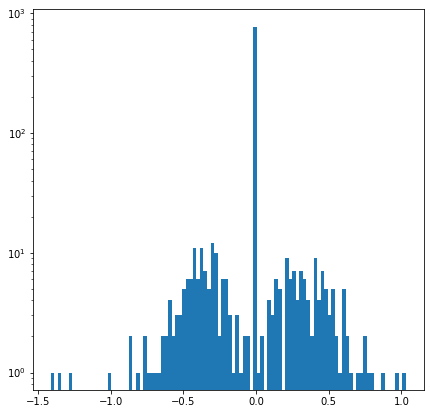

In [7]:
w = model.layers[0].weights[0].numpy()
h, b = np.histogram(w, bins=100)
plt.figure(figsize=(7, 7))
plt.bar(b[:-1], h, width=b[1] - b[0])
plt.semilogy()
print("% of zeros = {}".format(np.sum(w == 0) / np.size(w)))

Compare this to the first model:

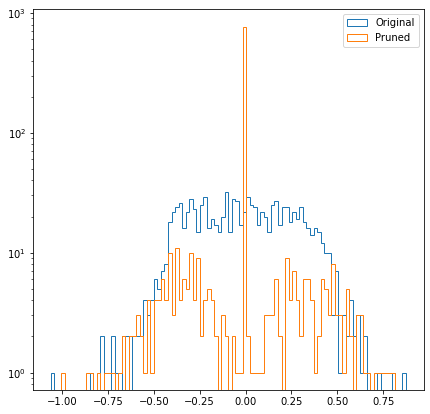

In [8]:
from tensorflow.keras.models import load_model

if not COLAB:
    model_orig = load_model("model_1/KERAS_check_best_model.h5") #locally
else:
    model_orig = load_model("iaifi-summer-school/book/model_1/KERAS_check_best_model.h5") #for colab

w_orig = model_orig.layers[0].weights[0].numpy().flatten()
w = model.layers[0].weights[0].numpy().flatten()
plt.figure(figsize=(7, 7))
_, bins, _ = plt.hist(w_orig, bins=100, label="Original", histtype="step")
plt.hist(w, bins=bins, label="Pruned", histtype="step")
plt.semilogy()
plt.legend()

## Check performance
How does this 75% sparse model compare against the unpruned model? Let's report the accuracy and make a ROC curve. The pruned model is shown with solid lines, the unpruned model is shown with dashed lines.

5188/5188 [==============================] - 4s 728us/step
Accuracy unpruned: 0.7516506024096385
Accuracy pruned:   0.7429879518072289


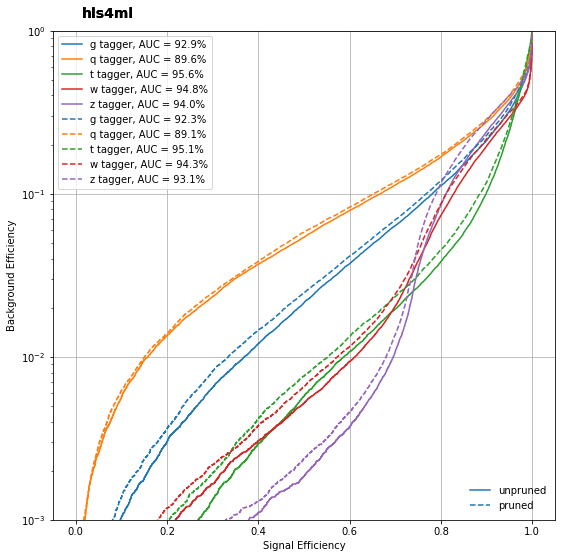

In [9]:
import plotting
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import load_model

if not COLAB:
    model_ref = load_model("model_1/KERAS_check_best_model.h5") #locally
else:
    model_ref = load_model("iaifi-summer-school/book/model_1/KERAS_check_best_model.h5") #for colab

y_ref = model_ref.predict(X_test)
y_prune = model.predict(X_test)

print(
    "Accuracy unpruned: {}".format(
        accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_ref, axis=1))
    )
)
print(
    "Accuracy pruned:   {}".format(
        accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_prune, axis=1))
    )
)

fig, ax = plt.subplots(figsize=(9, 9))
_ = plotting.makeRoc(y_test, y_ref, classes)
plt.gca().set_prop_cycle(None)  # reset the colors
_ = plotting.makeRoc(y_test, y_prune, classes, linestyle="--")

from matplotlib.lines import Line2D

lines = [Line2D([0], [0], ls="-"), Line2D([0], [0], ls="--")]
from matplotlib.legend import Legend

leg = Legend(ax, lines, labels=["unpruned", "pruned"], loc="lower right", frameon=False)
ax.add_artist(leg)

### Reduced size model

What if instead of pruning our model we simply shrink the size? Let's now train a model where the hidden layers are a quarter of the size they are in the original model: 3 hidden layers with 16, then 8, then 8 neurons. Each layer will use `relu` activation.
Add an output layer with 5 neurons (one for each class), then finish with Softmax activation.

In [10]:
model_small = Sequential()
model_small.add(
    Dense(
        16,
        input_shape=(16,),
        name="fc1",
        kernel_initializer="lecun_uniform",
        kernel_regularizer=l1(0.0001),
    )
)
model_small.add(Activation(activation="relu", name="relu1"))
model_small.add(
    Dense(
        8, name="fc2", kernel_initializer="lecun_uniform", kernel_regularizer=l1(0.0001)
    )
)
model_small.add(Activation(activation="relu", name="relu2"))
model_small.add(
    Dense(
        8, name="fc3", kernel_initializer="lecun_uniform", kernel_regularizer=l1(0.0001)
    )
)
model_small.add(Activation(activation="relu", name="relu3"))
model_small.add(
    Dense(
        5,
        name="output",
        kernel_initializer="lecun_uniform",
        kernel_regularizer=l1(0.0001),
    )
)
model_small.add(Activation(activation="softmax", name="softmax"))

In [11]:
train = True
if train:
    adam = Adam(lr=0.0001)
    model_small.compile(
        optimizer=adam, loss=["categorical_crossentropy"], metrics=["accuracy"]
    )
    callbacks = all_callbacks(
        stop_patience=1000,
        lr_factor=0.5,
        lr_patience=10,
        lr_epsilon=0.000001,
        lr_cooldown=2,
        lr_minimum=0.0000001,
        outputDir="model_1_half",
    )
    model_small.fit(
        X_train_val,
        y_train_val,
        batch_size=1024,
        epochs=30,
        validation_split=0.25,
        shuffle=True,
        callbacks=callbacks.callbacks,
    )
    model_small.save("model_1_small/KERAS_check_best_model.h5")
else:
    from tensorflow.keras.models import load_model

    model_small = load_model("model_1_small/KERAS_check_best_model.h5")

Epoch 1/30


/Users/wmccorma/miniconda3/envs/ml-iaifi/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


452/487 [==========================>...] - ETA: 0s - loss: 1.5647 - accuracy: 0.2630
***callbacks***
saving losses to model_1_half/losses.log

Epoch 1: val_loss improved from inf to 1.45849, saving model to model_1_half/KERAS_check_best_model.h5

Epoch 1: val_loss improved from inf to 1.45849, saving model to model_1_half/KERAS_check_best_model_weights.h5

Epoch 1: saving model to model_1_half/KERAS_check_model_last.h5

Epoch 1: saving model to model_1_half/KERAS_check_model_last_weights.h5

***callbacks end***

487/487 [==============================] - 2s 2ms/step - loss: 1.5577 - accuracy: 0.2705 - val_loss: 1.4585 - val_accuracy: 0.3769 - lr: 1.0000e-04
Epoch 2/30
477/487 [============================>.] - ETA: 0s - loss: 1.3490 - accuracy: 0.4994
***callbacks***
saving losses to model_1_half/losses.log

Epoch 2: val_loss improved from 1.45849 to 1.24289, saving model to model_1_half/KERAS_check_best_model.h5

Epoch 2: val_loss improved from 1.45849 to 1.24289, saving model to mode


Epoch 12: saving model to model_1_half/KERAS_check_model_last.h5

Epoch 12: saving model to model_1_half/KERAS_check_model_last_weights.h5

***callbacks end***

487/487 [==============================] - 1s 2ms/step - loss: 0.8910 - accuracy: 0.7050 - val_loss: 0.8867 - val_accuracy: 0.7075 - lr: 1.0000e-04
Epoch 13/30
452/487 [==========================>...] - ETA: 0s - loss: 0.8765 - accuracy: 0.7105
***callbacks***
saving losses to model_1_half/losses.log

Epoch 13: val_loss improved from 0.88672 to 0.87253, saving model to model_1_half/KERAS_check_best_model.h5

Epoch 13: val_loss improved from 0.88672 to 0.87253, saving model to model_1_half/KERAS_check_best_model_weights.h5

Epoch 13: saving model to model_1_half/KERAS_check_model_last.h5

Epoch 13: saving model to model_1_half/KERAS_check_model_last_weights.h5

***callbacks end***

487/487 [==============================] - 1s 2ms/step - loss: 0.8759 - accuracy: 0.7106 - val_loss: 0.8725 - val_accuracy: 0.7124 - lr: 1.0000e-04



Epoch 24: val_loss improved from 0.80257 to 0.79940, saving model to model_1_half/KERAS_check_best_model_weights.h5

Epoch 24: saving model to model_1_half/KERAS_check_model_last.h5

Epoch 24: saving model to model_1_half/KERAS_check_model_last_weights.h5

***callbacks end***

487/487 [==============================] - 1s 2ms/step - loss: 0.7971 - accuracy: 0.7288 - val_loss: 0.7994 - val_accuracy: 0.7288 - lr: 1.0000e-04
Epoch 25/30
448/487 [==========================>...] - ETA: 0s - loss: 0.7943 - accuracy: 0.7291
***callbacks***
saving losses to model_1_half/losses.log

Epoch 25: val_loss improved from 0.79940 to 0.79659, saving model to model_1_half/KERAS_check_best_model.h5

Epoch 25: val_loss improved from 0.79940 to 0.79659, saving model to model_1_half/KERAS_check_best_model_weights.h5

Epoch 25: saving model to model_1_half/KERAS_check_model_last.h5

Epoch 25: saving model to model_1_half/KERAS_check_model_last_weights.h5

***callbacks end***

487/487 [======================

How does this small model compare in terms of performance?

5188/5188 [==============================] - 3s 614us/step
Accuracy unpruned: 0.7516506024096385
Accuracy pruned:   0.7429879518072289
Accuracy small:    0.7301265060240963


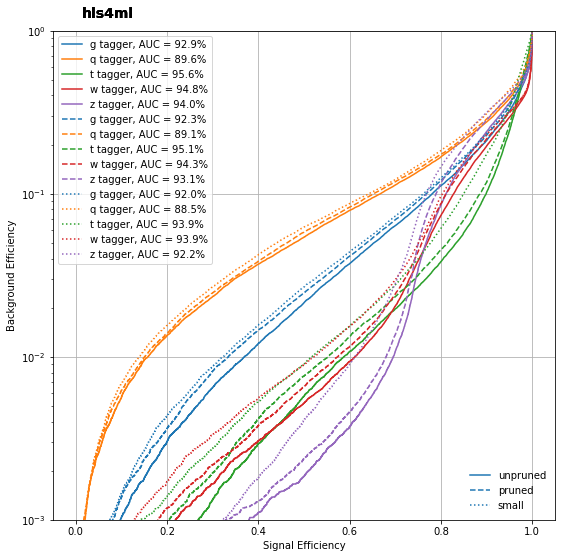

In [12]:
import plotting
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import load_model

if not COLAB:
    model_ref = load_model("model_1/KERAS_check_best_model.h5")
else:
    model_ref = load_model("iaifi-summer-school/book/model_1/KERAS_check_best_model.h5")

y_ref = model_ref.predict(X_test)
y_prune = model.predict(X_test)
y_small = model_small.predict(X_test)

print(
    "Accuracy unpruned: {}".format(
        accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_ref, axis=1))
    )
)
print(
    "Accuracy pruned:   {}".format(
        accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_prune, axis=1))
    )
)
print(
    "Accuracy small:    {}".format(
        accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_small, axis=1))
    )
)

fig, ax = plt.subplots(figsize=(9, 9))
_ = plotting.makeRoc(y_test, y_ref, classes)
plt.gca().set_prop_cycle(None)  # reset the colors
_ = plotting.makeRoc(y_test, y_prune, classes, linestyle="--")
plt.gca().set_prop_cycle(None)  # reset the colors
_ = plotting.makeRoc(y_test, y_small, classes, linestyle=":")

from matplotlib.lines import Line2D

lines = [Line2D([0], [0], ls="-"), Line2D([0], [0], ls="--"), Line2D([0], [0], ls=":")]
from matplotlib.legend import Legend

leg = Legend(
    ax, lines, labels=["unpruned", "pruned", "small"], loc="lower right", frameon=False
)
ax.add_artist(leg)

This looks quite good. Can we go further? Let's try a sparsity of 95%.

In [13]:
from tensorflow_model_optimization.python.core.sparsity.keras import (
    prune,
    pruning_callbacks,
    pruning_schedule,
)
from tensorflow_model_optimization.sparsity.keras import strip_pruning

pruning_params = {
    "pruning_schedule": pruning_schedule.ConstantSparsity(
        0.95, begin_step=2000, frequency=100
    )
}
model = prune.prune_low_magnitude(model, **pruning_params)

## Train the model
We'll use the same settings as the model for part 1: Adam optimizer with categorical crossentropy loss.
The callbacks will decay the learning rate and save the model into a directory 'model_2'
The model isn't very complex, so this should just take a few minutes even on the CPU.
If you've restarted the notebook kernel after training once, set `train = False` to load the trained model rather than training again.

In [14]:
train = True
if train:
    adam = Adam(lr=0.0001)
    model.compile(
        optimizer=adam, loss=["categorical_crossentropy"], metrics=["accuracy"]
    )
    callbacks = all_callbacks(
        stop_patience=1000,
        lr_factor=0.5,
        lr_patience=10,
        lr_epsilon=0.000001,
        lr_cooldown=2,
        lr_minimum=0.0000001,
        outputDir="model_4",
    )
    callbacks.callbacks.append(pruning_callbacks.UpdatePruningStep())
    model.fit(
        X_train_val,
        y_train_val,
        batch_size=1024,
        epochs=30,
        validation_split=0.25,
        shuffle=True,
        callbacks=callbacks.callbacks,
    )
    # Save the model again but with the pruning 'stripped' to use the regular layer types
    model = strip_pruning(model)
    model.save("model_4/KERAS_check_best_model.h5")
else:
    from tensorflow.keras.models import load_model

    model = load_model("model_4/KERAS_check_best_model.h5")

Epoch 1/30


/Users/wmccorma/miniconda3/envs/ml-iaifi/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


464/487 [===========================>..] - ETA: 0s - loss: 0.7543 - accuracy: 0.7457
***callbacks***
saving losses to model_4/losses.log

Epoch 1: val_loss improved from inf to 0.75662, saving model to model_4/KERAS_check_best_model.h5

Epoch 1: val_loss improved from inf to 0.75662, saving model to model_4/KERAS_check_best_model_weights.h5

Epoch 1: saving model to model_4/KERAS_check_model_last.h5

Epoch 1: saving model to model_4/KERAS_check_model_last_weights.h5

***callbacks end***

487/487 [==============================] - 3s 3ms/step - loss: 0.7540 - accuracy: 0.7458 - val_loss: 0.7566 - val_accuracy: 0.7457 - lr: 1.0000e-04
Epoch 2/30
480/487 [============================>.] - ETA: 0s - loss: 0.7504 - accuracy: 0.7468
***callbacks***
saving losses to model_4/losses.log

Epoch 2: val_loss improved from 0.75662 to 0.75323, saving model to model_4/KERAS_check_best_model.h5

Epoch 2: val_loss improved from 0.75662 to 0.75323, saving model to model_4/KERAS_check_best_model_weights.


Epoch 14: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.

***callbacks end***

487/487 [==============================] - 1s 2ms/step - loss: 1.0285 - accuracy: 0.5877 - val_loss: 1.0255 - val_accuracy: 0.5863 - lr: 1.0000e-04
Epoch 15/30
476/487 [============================>.] - ETA: 0s - loss: 1.0209 - accuracy: 0.5889
***callbacks***
saving losses to model_4/losses.log

Epoch 15: val_loss did not improve from 0.74793

Epoch 15: val_loss did not improve from 0.74793

Epoch 15: saving model to model_4/KERAS_check_model_last.h5

Epoch 15: saving model to model_4/KERAS_check_model_last_weights.h5

***callbacks end***

487/487 [==============================] - 1s 3ms/step - loss: 1.0205 - accuracy: 0.5890 - val_loss: 1.0205 - val_accuracy: 0.5870 - lr: 5.0000e-05
Epoch 16/30
484/487 [============================>.] - ETA: 0s - loss: 1.0156 - accuracy: 0.5898
***callbacks***
saving losses to model_4/losses.log

Epoch 16: val_loss did not improve from 0.74793

Epoch 


Epoch 29: val_loss did not improve from 0.74793

Epoch 29: saving model to model_4/KERAS_check_model_last.h5

Epoch 29: saving model to model_4/KERAS_check_model_last_weights.h5

***callbacks end***

487/487 [==============================] - 1s 2ms/step - loss: 0.9670 - accuracy: 0.5952 - val_loss: 0.9684 - val_accuracy: 0.5934 - lr: 2.5000e-05
Epoch 30/30
468/487 [===========================>..] - ETA: 0s - loss: 0.9646 - accuracy: 0.5958
***callbacks***
saving losses to model_4/losses.log

Epoch 30: val_loss did not improve from 0.74793

Epoch 30: val_loss did not improve from 0.74793

Epoch 30: saving model to model_4/KERAS_check_model_last.h5

Epoch 30: saving model to model_4/KERAS_check_model_last_weights.h5

Epoch 30: saving model to model_4/KERAS_check_model_epoch30.h5

***callbacks end***

487/487 [==============================] - 1s 3ms/step - loss: 0.9646 - accuracy: 0.5958 - val_loss: 0.9659 - val_accuracy: 0.5941 - lr: 2.5000e-05


## Check sparsity

% of zeros = 0.9501953125


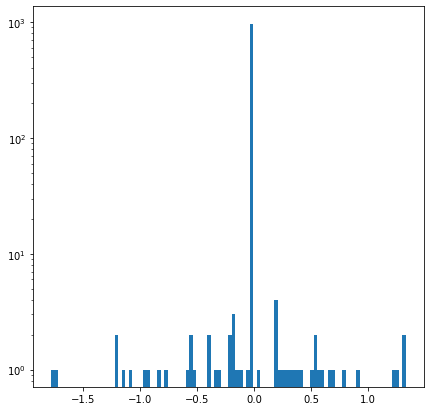

In [15]:
w = model.layers[0].weights[0].numpy()
h, b = np.histogram(w, bins=100)
plt.figure(figsize=(7, 7))
plt.bar(b[:-1], h, width=b[1] - b[0])
plt.semilogy()
print("% of zeros = {}".format(np.sum(w == 0) / np.size(w)))

## Check performance
How does this 95% sparse model compare against the other models?

5188/5188 [==============================] - 4s 709us/step
Accuracy unpruned:     0.7516506024096385
Accuracy pruned (75%): 0.7493855421686747
Accuracy pruned (95%): 0.5956506024096385


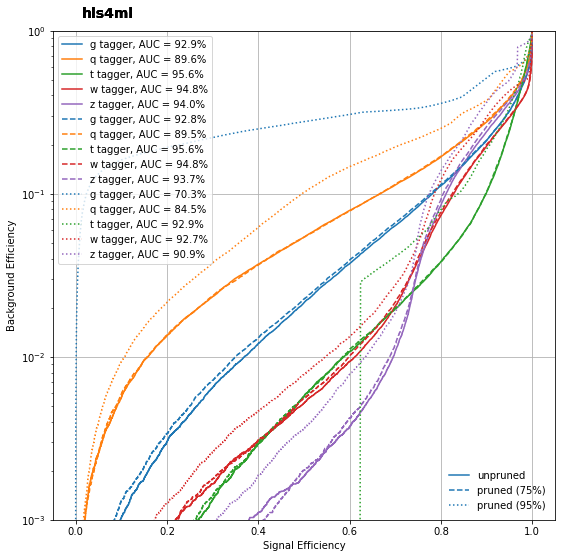

In [16]:
import plotting
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import load_model

if not COLAB:
    model_ref = load_model("model_1/KERAS_check_best_model.h5")
    model_prune75 = load_model("model_2/KERAS_check_best_model.h5")
else:
    model_ref = load_model("iaifi-summer-school/book/model_1/KERAS_check_best_model.h5")
    model_prune75 = load_model("iaifi-summer-school/book/model_2/KERAS_check_best_model.h5")

y_ref = model_ref.predict(X_test)
y_prune75 = model_prune75.predict(X_test)
y_prune95 = model.predict(X_test)

print(
    "Accuracy unpruned:     {}".format(
        accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_ref, axis=1))
    )
)
print(
    "Accuracy pruned (75%): {}".format(
        accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_prune75, axis=1))
    )
)
print(
    "Accuracy pruned (95%): {}".format(
        accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_prune95, axis=1))
    )
)

fig, ax = plt.subplots(figsize=(9, 9))
_ = plotting.makeRoc(y_test, y_ref, classes)
plt.gca().set_prop_cycle(None)  # reset the colors
_ = plotting.makeRoc(y_test, y_prune75, classes, linestyle="--")
plt.gca().set_prop_cycle(None)  # reset the colors
_ = plotting.makeRoc(y_test, y_prune95, classes, linestyle=":")

from matplotlib.lines import Line2D

lines = [Line2D([0], [0], ls="-"), Line2D([0], [0], ls="--"), Line2D([0], [0], ls=":")]
from matplotlib.legend import Legend

leg = Legend(
    ax,
    lines,
    labels=["unpruned", "pruned (75%)", "pruned (95%)"],
    loc="lower right",
    frameon=False,
)
ax.add_artist(leg)

Ok, clearly 95% is too sparse for this model (at least using this scheme). For some classes you see that the performance is not terrible, but overall the performance loss is quite substantial.